In [1]:
import gc
import numpy as np
import pandas as pd
from rnn_mimic import return_loaded_model, get_percentages, get_pickle_path, load_pickle
from seaborn import heatmap
import seaborn as sns
import pickle
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import kurtosis

# plot part.
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import torch
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

0
1
GeForce RTX 2060
True


In [2]:
target = 'SEPSIS'
figure_format = 'png'

In [3]:
## PICKLE LOADS
path = get_pickle_path()

X_TRAIN = load_pickle(path.format('X_TRAIN', target))
Y_TRAIN = load_pickle(path.format('Y_TRAIN', target))
X_VAL = load_pickle(path.format('X_VAL', target))
Y_VAL = load_pickle(path.format('Y_VAL', target))
X_TEST = load_pickle(path.format('X_TEST', target))
Y_TEST = load_pickle(path.format('Y_TEST', target))
x_boolmat_test = load_pickle(path.format('x_boolmat_test', target))
y_boolmat_test = load_pickle(path.format('y_boolmat_test', target))
no_feature_cols = load_pickle(path.format('no_feature_cols', target))
features = load_pickle(path.format('features', target))

if target == 'MI':
    my_cmap = ListedColormap(sns.color_palette("Reds", 150))
    color_list = sns.color_palette("Reds", 14)
    color_list_reduced = sns.color_palette("Reds", 7) 
elif target == 'SEPSIS':
    my_cmap = sns.cubehelix_palette(14, start=2, rot=0, dark=0.25, light=.95, as_cmap=True)
    color_list = sns.cubehelix_palette(14, start=2, rot=0, dark=0.15, light=.8)
    color_list_reduced = sns.cubehelix_palette(7, start=2, rot=0, dark=0.15, light=.8)
elif target == 'VANCOMYCIN':
    my_cmap= sns.cubehelix_palette(14, as_cmap=True)
    color_list = sns.cubehelix_palette(14)
    color_list_reduced = sns.cubehelix_palette(7)
    
Y_TOTAL = np.concatenate([Y_TRAIN, Y_VAL, Y_TEST], axis=0)

In [4]:
Y = np.concatenate([Y_TRAIN, Y_VAL], axis=0)
print(np.sum(np.sum(Y.squeeze(), axis=1) > 0))
print(no_feature_cols)

print(X_TRAIN.shape)

20766
225
(36304, 14, 225)


In [5]:
TIME_STEPS = X_VAL.shape[1] #number of time_steps

In [6]:
def load_model(target, percent):
    model_name = 'kaji_mach_final_no_mask_{0}_pad14_{1}_percent'
    return return_loaded_model(model_name.format(target, percent)).cpu()
    
percentage_strings = [str(int(p *100)) for p in get_percentages()]

model_dict = dict()
m = percentage_strings[0]
for p_str in percentage_strings:
    model_dict[p_str] = load_model(target, p_str)

model_dict.keys()

dict_keys(['100', '80', '60', '40', '20', '10', '5'])

The total kurtosis is 0.03958649563324812 with 36.85836630711692 % of events occuring between days 0 and 2
The train kurtosis is 0.023885098095904223 with 36.77022940462662 % of events occuring between days 0 and 2
The test kurtosis is 0.05940773131786381 with 37.5129748806311 % of events occuring between days 0 and 2


<Figure size 432x288 with 0 Axes>

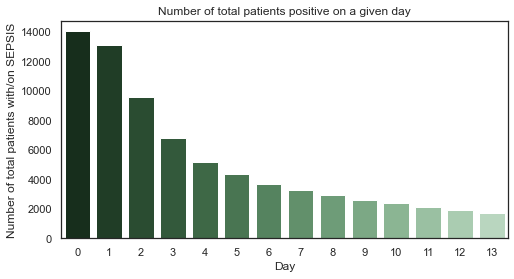

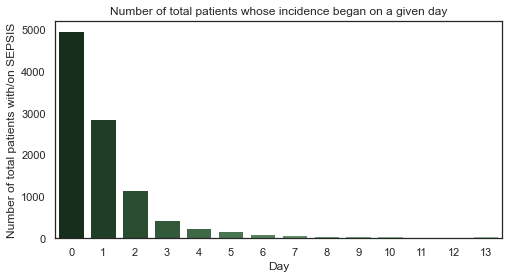

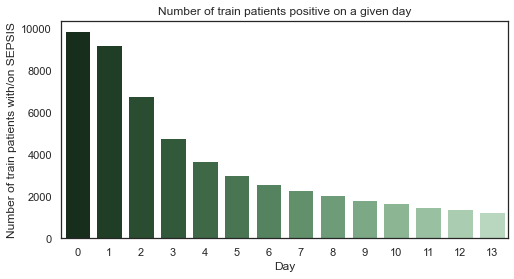

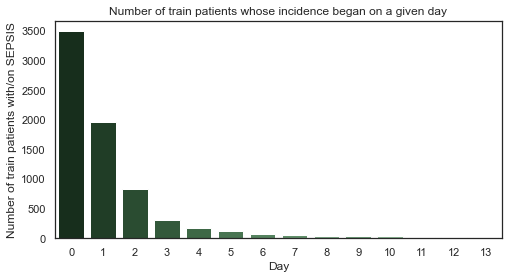

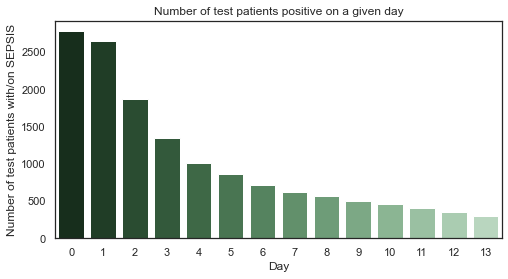

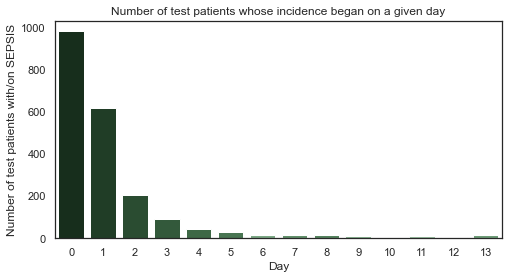

In [7]:
############################
## SUPPLEMENTARY FIGURE 1 ##
############################

sns.set(style="white")
sns.despine(left=True, bottom=True)
    
## TOTAL

### When do people have incidents?

# number of people who are positive on a given day
plt.figure(figsize = (8,4))
plt.title('Number of total patients positive on a given day')
plt.ylabel('Number of total patients with/on {0}'.format(target))
plt.xlabel('Day')
y_vector_total = np.nansum(Y_TOTAL, axis=0).squeeze()
print("The total kurtosis is {0} with {1} % of events \
occuring between days 0 and 2".format(kurtosis(y_vector_total), 
                                            100*int(np.sum(y_vector_total[0:2]))/np.sum(y_vector_total)))
color_rank = np.argsort(np.argsort(y_vector_total))
sns.barplot(y=y_vector_total, x=np.arange(14), palette=np.array(color_list)[color_rank])

plt.savefig('./figures/{0}_Total_Patients_Positive_Supplemental_Figure_1.{1}'.format(target, figure_format),
            format=figure_format, dpi=300, bbox_inches='tight')

# first incident - number of people who had their first incident on a given day
plt.figure(figsize = (8,4))
plt.title('Number of total patients whose incidence began on a given day')
plt.ylabel('Number of total patients with/on {0}'.format(target))
plt.xlabel('Day')
POS_Y_TOTAL = Y_TOTAL[np.nansum(Y_TOTAL.squeeze(), axis=1) == 1]
(days_total, value_counts_total) = np.unique(np.nanargmax(POS_Y_TOTAL, axis=1), return_counts=True)
day_value_dict_total = dict(zip(np.arange(14), np.zeros(14)))
for i in range(len(days_total)):
    day_value_dict_total[days_total[i]] = value_counts_total[i]
y_vector_total_pos = list(day_value_dict_total.values())
color_rank = np.argsort(np.argsort(y_vector_total_pos))
sns.barplot(y=y_vector_total_pos, x=np.arange(14), palette=np.array(color_list)[color_rank])
#plt.show()

plt.savefig('./figures/{0}_Total_Patients_First_Positive_Supplemental_Figure_1.{1}'.format(target, figure_format), 
            format=figure_format, dpi=300, bbox_inches='tight')

## TRAIN

## When do people have incidents?

# number of people who are positive on a given day
plt.figure(figsize = (8,4))
plt.title('Number of train patients positive on a given day')
plt.ylabel('Number of train patients with/on {0}'.format(target))
plt.xlabel('Day')
y_vector_train = np.nansum(Y_TRAIN, axis=0).squeeze()
print("The train kurtosis is {0} with {1} % of events \
occuring between days 0 and 2".format(kurtosis(y_vector_train), 
                                            100*int(np.sum(y_vector_train[0:2]))/np.sum(y_vector_train)))
color_rank = np.argsort(np.argsort(y_vector_train))
sns.barplot(y=y_vector_train, x=np.arange(14), palette=np.array(color_list)[color_rank])

plt.savefig('./figures/{0}_Train_Patients_Positive_Supplemental_Figure_1.{1}'.format(target, figure_format),
            format=figure_format, dpi=300, bbox_inches='tight')


# first incident - number of people who had their first incident on a given day
plt.figure(figsize = (8,4))
plt.title('Number of train patients whose incidence began on a given day')
plt.ylabel('Number of train patients with/on {0}'.format(target))
plt.xlabel('Day')
POS_Y_TRAIN = Y_TRAIN[np.nansum(Y_TRAIN.squeeze(), axis=1) == 1]
(days_train_pos, value_counts_train_pos) = np.unique(np.nanargmax(POS_Y_TRAIN, axis=1), return_counts=True)
day_value_dict_train_pos = dict(zip(np.arange(14), np.zeros(14)))
for i in range(len(days_train_pos)):
    day_value_dict_train_pos[days_train_pos[i]] = value_counts_train_pos[i]
y_vector_train_pos = list(day_value_dict_train_pos.values())
color_rank = np.argsort(np.argsort(y_vector_train_pos))
sns.barplot(y=y_vector_train_pos, x=np.arange(14), palette=np.array(color_list)[color_rank])

plt.savefig('./figures/{0}_Train_Patients_First_Positive_Supplemental_Figure_1.{1}'.format(target, figure_format), 
            format=figure_format, dpi=300, bbox_inches='tight')

## TEST

# number of people who are positive on a given day
plt.figure(figsize = (8,4))
plt.title('Number of test patients positive on a given day')
plt.ylabel('Number of test patients with/on {0}'.format(target))
plt.xlabel('Day')
y_vector_test = np.nansum(Y_TEST, axis=0).squeeze()
print("The test kurtosis is {0} with {1} % of events \
occuring between days 0 and 2".format(kurtosis(y_vector_test), 
                                          100*int(np.sum(y_vector_test[0:2]))/np.sum(y_vector_test)))
color_rank = np.argsort(np.argsort(y_vector_test))
sns.barplot(y=y_vector_test, x=np.arange(14), palette=np.array(color_list)[color_rank])

plt.savefig('./figures/{0}_Test_Patients_Positive_Supplemental_Figure_1.{1}'.format(target, figure_format), 
            format=figure_format, dpi=300, bbox_inches='tight')

# first incident - nmber of people who had their first incident on a given day
plt.figure(figsize = (8,4))
plt.title('Number of test patients whose incidence began on a given day')
plt.ylabel('Number of test patients with/on {0}'.format(target))
plt.xlabel('Day')
POS_Y_TEST = Y_TEST[np.nansum(Y_TEST.squeeze(), axis=1) == 1]
(days, value_counts) = np.unique(np.nanargmax(POS_Y_TEST, axis=1), return_counts=True)
day_value_dict = dict(zip(np.arange(14), np.zeros(14)))
for i in range(len(days)):
    day_value_dict[days[i]] = value_counts[i]
y_vector_test_pos = list(day_value_dict.values())
color_rank = np.argsort(np.argsort(y_vector_test_pos))
sns.barplot(y=y_vector_test_pos, x=np.arange(14), palette=np.array(color_list)[color_rank])

plt.savefig('./figures/{0}_Test_Patients_First_Positive_Supplemental_Figure_1.{1}'.format(target, figure_format), 
            format=figure_format, dpi=300, bbox_inches='tight')

In [8]:
#############################
## SUPPLEMENTARY FIGURE 2 ###
#############################
y_pred_dict = dict()
with torch.no_grad():
    X_TEST = torch.tensor(X_TEST, dtype=torch.float)
    X_TEST_MASK = X_TEST.clone().detach()
    X_TEST_MASK[x_boolmat_test] = 0
    for p_str in percentage_strings:
        prediction, hidden = model_dict[p_str](X_TEST_MASK)
        y_pred_dict[p_str] = prediction.detach().numpy()

In [9]:
X_TEST_MASK[0,:,0]

tensor([ 2.7179,  2.8981,  2.0275,  1.4571,  1.4571,  1.8173,  1.4571, -0.8846,
        -0.8846, -0.8846, -0.8846, -0.8846, -0.8846, -0.8846])

In [10]:
#############################
## SUPPLEMENTARY FIGURE 2 ###
#############################
# AUROC values with models that have been trained with various fractions of training data
fpr_tpr_dict = dict()
for p_str in percentage_strings:
    (fpr, tpr, thresholds) = roc_curve(Y_TEST[~y_boolmat_test], y_pred_dict[p_str][~y_boolmat_test])
    fpr_tpr_dict[p_str] = (fpr, tpr)

fpr_tprs = fpr_tpr_dict.values()

0.9514236141453409
0.9520498227341523
0.9484786267858666
0.9485869591393383
0.9389132446209699
0.9235639660531221
0.8923980491808037
PPV for full model is 0.7536998696418986
Sensitivity for full model is 0.68
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     75415
         1.0       0.75      0.68      0.72     14451

    accuracy                           0.91     89866
   macro avg       0.85      0.82      0.83     89866
weighted avg       0.91      0.91      0.91     89866



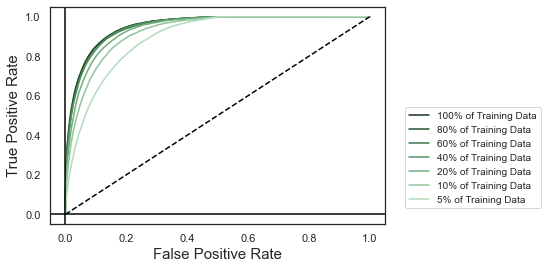

In [11]:
#############################
## SUPPLEMENTARY FIGURE 2 ###
#############################

fig, ax = plt.subplots()
ax.set_facecolor('white')

for color, fpr_tpr_tuple, i in zip(np.array(color_list_reduced)[::-1], fpr_tprs, [100,80,60,40,20,10,5]):
    plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='{0}% of Training Data'.format(i), color=color)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.48, 0.05))
plt.savefig('./figures/{0}_less_data_roc_curves_Supplemental_Figure_2.{1}'.format(target, figure_format),
            format=figure_format, dpi=300, facecolor='white', transparent=True,
            bbox_extra_artists=(legend,), bbox_inches='tight')

for p_str in percentage_strings:
    # p % Training Data
    print(roc_auc_score(Y_TEST[~y_boolmat_test], y_pred_dict[p_str][~y_boolmat_test]))

## 100% Training Data ##
Y_PRED_mask_0 = y_pred_dict[m]
TN, FP, FN, TP = confusion_matrix(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test])).ravel()
PPV = TP/(TP+FP)
print("PPV for full model is {0}".format(PPV))
CR = classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test]))

print("Sensitivity for full model is {0}".format(CR.split('\n')[3].split()[2]))
# classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test]))

print(classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test])))

In [12]:
# GET ACTIVATIONS MATRIX ; OUTPUT IS (BATCH_SIZE, TIME_STEPS, FEATURES)
model_dict[m](X_TEST)
activations = model_dict[m].attention
activations[x_boolmat_test] = np.nan

# AVERAGE THE ATTENTION MATRIX OVER FEATURES ; OUTPUT IS BATCH_SIZE, TIME_STEPS
attention_matrix = np.nanmean(activations, axis=2).squeeze()

# AVERAGE ATTENTION VECTOR ACROSS SAMPLES ; OUTPUT IS 1D TIME_STEPS
attention_vector_final = np.nanmean(attention_matrix, axis=0)

# This allows us to rank color intensity by activation. We sort the intensities, then argsort the indices ##
color_order = np.argsort(attention_vector_final, axis=0)
color_order_order = np.argsort(color_order)

<ipython-input-12-605ce7a39692>:7: RuntimeWarning: Mean of empty slice
  attention_matrix = np.nanmean(activations, axis=2).squeeze()


In [13]:
attention_vector_final

array([0.07903354, 0.07925133, 0.07395071, 0.07349204, 0.07063765,
       0.06857084, 0.0676265 , 0.06760927, 0.06706093, 0.06570574,
       0.06863046, 0.06327831, 0.06677428, 0.06254902], dtype=float32)

In [14]:
''' Due to the way features are selectd from the EMR and the fact potassium can be a 
delivered medication or a lab value, special care was taken to ensure proper representation on heatmaps '''

if 'digoxin(?!.*fab)' in features:
    indexy = features.index('digoxin(?!.*fab)')
    features[indexy] = 'digoxin'
    
if 'potassium_y' in features:
    indexy = features.index('potassium_y')
    features[indexy] = 'potassium_med'
    
if 'potassium_x' in features:
    indexy = features.index('potassium_x')
    features[indexy] = 'potassium'
    
if 'cipfloxacin' in features:
    indexy = features.index('cipfloxacin')
    features[indexy] = 'ciprofloxacin'

features = [feature.lower() for feature in features]

In [15]:
## FEATURES BY CATEGORY ##

cbc_diff_features = ['RBCs', 'WBCs', 'platelets', 'hemoglobin', 'hemocrit', 
                              'atypical lymphocytes', 'bands', 'basophils', 'eosinophils', 'neutrophils',
                              'lymphocytes', 'monocytes', 'polymorphonuclear leukocytes']
                      
vital_features = ['temperature (F)', 'heart rate', 'respiratory rate', 'systolic', 'diastolic',
                  'pulse oximetry']

lab_features = ['troponin', 'HDL', 'LDL', 'BUN', 'INR', 'PTT', 'PT', 'triglycerides', 'creatinine',
                  'glucose', 'sodium', 'potassium', 'chloride', 'bicarbonate',
                  'blood culture', 'urine culture', 'surface culture', 'sputum' + 
                  ' culture', 'wound culture', 'Inspired O2 Fraction', 'central venous pressure', 
                  'PEEP Set', 'tidal volume', 'anion gap']
                  
demographic_features = ['age', 'm', 'black', 'daily weight', 'tobacco', 'diabetes', 'history of CV events']

med_features = ['epoetin', 'warfarin', 'heparin', 'enoxaparin', 'fondaparinux',
                                      'asprin', 'ketorolac', 'acetominophen', 
                                      'insulin', 'glucagon', 
                                      'potassium_med', 'calcium gluconate', 
                                      'fentanyl', 'magensium sulfate', 
                                      'D5W', 'dextrose', 
                                      'ranitidine', 'ondansetron', 'pantoprazole', 'metoclopramide', 
                                      'lisinopril', 'captopril', 'statin',  
                                      'hydralazine', 'diltiazem', 
                                      'carvedilol', 'metoprolol', 'labetalol', 'atenolol',
                                      'amiodarone', 'digoxin',
                                      'clopidogrel', 'nitroprusside', 'nitroglycerin',
                                      'vasopressin', 'hydrochlorothiazide', 'furosemide', 
                                      'atropine', 'neostigmine',
                                      'levothyroxine',
                                      'oxycodone', 'hydromorphone', 'fentanyl citrate', 
                                      'tacrolimus', 'prednisone', 
                                      'phenylephrine', 'norepinephrine',
                                      'haloperidol', 'phenytoin', 'trazodone', 'levetiracetam',
                                      'diazepam', 'clonazepam',
                                      'propofol', 'zolpidem', 'midazolam', 
                                      'albuterol', 'ipratropium', 
                                      'diphenhydramine',  
                                      '0.9% Sodium Chloride',
                                      'phytonadione', 
                                      'metronidazole', 
                                      'cefazolin', 'cefepime', 'vancomycin', 'levofloxacin',
                                      'ciprofloxacin', 'fluconazole', 
                                      'meropenem', 'ceftriaxone', 'piperacillin',
                                      'ampicillin-sulbactam', 'nafcillin', 'oxacillin',
                                      'amoxicillin', 'penicillin', 'SMX-TMP']

cbc_diff_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in cbc_diff_features]
vital_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in vital_features]
lab_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in lab_features]
demographic_features = [i.lower() for i in demographic_features]
med_features = [i.lower() for i in med_features]

cbc_diff_feature_array = np.array(cbc_diff_features).flatten()
vital_features_array = np.array(vital_features).flatten()
lab_features_array = np.array(lab_features).flatten()
demographic_feature_array = np.array(demographic_features).flatten()
med_features_array = np.array(med_features).flatten()

features_built = np.hstack([cbc_diff_feature_array,vital_features_array,
                            lab_features_array,demographic_feature_array,med_features_array])

features_built_reduced = [i for i in features_built if i in features]

In [16]:
## Identifies the index in the features list in the desired order ##
arranged_indices = [features.index(i) for i in features_built_reduced]
## This is a sanity check to ensure that features_built_reduced has the same number of elements as our target ##
print(len(features))
print(len(features_built_reduced))
assert len(features) == len(features_built_reduced)

225
225


In [17]:
##############
## FIGURE 1 ##
##############
#Set padding as well as defined number of days (mask) to zero
#Y_PRED_mask_X has set days from X onward to 0
mask_value = 0
y_pred_mask_dict = dict()
with torch.no_grad():
    X_TEST_MASK = X_TEST.clone().detach()
    X_TEST_MASK[x_boolmat_test] = 0

    prediction, hidden = model_dict[m](X_TEST_MASK)
    y_pred_mask_dict[0] = prediction.detach().numpy()
    print(X_TEST_MASK[4,:,0])
    print(prediction[4,:,0])
    print()
    for mask in reversed(range(1, TIME_STEPS)):
        X_TEST_MASK[:,mask,:] = mask_value
        prediction, hidden = model_dict[m](X_TEST_MASK.clone().detach())
        print(X_TEST_MASK[4,:,0])
        print(prediction[4,:,0])
        print()
        y_pred_mask_dict[mask] = prediction.detach().numpy()

tensor([ 0.4964, -0.1041, -0.1041,  0.1161, -0.0440, -0.0440, -0.2241, -0.3442,
        -0.8846, -0.8846, -0.8846, -0.8846,  0.0000,  0.0000])
tensor([3.3692e-01, 6.9452e-01, 6.7429e-01, 6.7582e-01, 9.9762e-02, 4.0823e-02,
        3.1696e-02, 6.0024e-02, 1.9972e-07, 2.4698e-07, 2.2159e-07, 5.1146e-07,
        2.9505e-04, 2.9554e-04])

tensor([ 0.4964, -0.1041, -0.1041,  0.1161, -0.0440, -0.0440, -0.2241, -0.3442,
        -0.8846, -0.8846, -0.8846, -0.8846,  0.0000,  0.0000])
tensor([3.3666e-01, 6.9458e-01, 6.7360e-01, 6.7416e-01, 9.9630e-02, 4.1070e-02,
        3.1694e-02, 6.0033e-02, 1.9871e-07, 2.4566e-07, 2.2053e-07, 5.1423e-07,
        2.9433e-04, 3.0498e-04])

tensor([ 0.4964, -0.1041, -0.1041,  0.1161, -0.0440, -0.0440, -0.2241, -0.3442,
        -0.8846, -0.8846, -0.8846, -0.8846,  0.0000,  0.0000])
tensor([3.3639e-01, 6.9393e-01, 6.7416e-01, 6.7671e-01, 9.9428e-02, 4.0817e-02,
        3.1432e-02, 5.9992e-02, 1.9903e-07, 2.4473e-07, 2.2084e-07, 5.1136e-07,
        3.0498e-04, 3.0

In [18]:
#Proving that the model does remember its prior states but 
#only returns a specific value if the inputs are pad values only
#for tensorflow 2.3.1
X_TEST_MASK = X_TEST.clone().detach().numpy()
mask = 2
X_TEST_MASK[x_boolmat_test] = 0
X_TEST_MASK[:,mask:,:] = 0
# Selecting first 3 samples
X_TEST_MASK = X_TEST_MASK[0:3,:,:]
# Setting the 2. day features of the first 2 samples to that of the third
X_TEST_MASK[0:2,1,:] = X_TEST_MASK[2,1,:]
#Printing first 5 features
print(f"Data X:\n{X_TEST_MASK[:,:4,0:5]}\nPrediction Y:")
model_dict[m](torch.tensor(X_TEST_MASK))[0][:,:4,:]

Data X:
[[[ 2.7179496   0.83547425  0.61017567  0.82873034  0.83531797]
  [ 0.6764948   0.83547425  0.766286    0.82873034  0.83531797]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.8846178  -1.1952248  -1.1850933  -1.1804954  -1.1950452 ]
  [ 0.6764948   0.83547425  0.766286    0.82873034  0.83531797]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 1.0967944   0.83547425  0.766286    0.62780774  0.83531797]
  [ 0.6764948   0.83547425  0.766286    0.82873034  0.83531797]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]]
Prediction Y:


tensor([[[2.9682e-01],
         [3.5717e-01],
         [1.2938e-03],
         [1.2938e-03]],

        [[5.4090e-07],
         [1.9112e-01],
         [7.7471e-04],
         [7.7471e-04]],

        [[8.4613e-01],
         [3.1081e-01],
         [4.1349e-04],
         [4.1349e-04]]], grad_fn=<SliceBackward>)

In [19]:
##############
## FIGURE 1 ##
##############

#~y_boolmat_test yields all non padded entries
#Y_PRED_mask_X[~y_boolmat_test] yields an array of
#non padded entries where from day X onward the entries are set to 0
#Because the network was trained with padding values I assume that it automatically returns the same result 
#ignoring the prior states
fpr_tpr_dict = dict()
for mask in reversed(y_pred_mask_dict.keys()):
    (fpr, tpr, thresholds) = roc_curve(Y_TEST[~y_boolmat_test], y_pred_mask_dict[mask][~y_boolmat_test])
    fpr_tpr_dict[mask] = (fpr, tpr)
    roc_auc = roc_auc_score(Y_TEST[~y_boolmat_test], y_pred_mask_dict[mask][~y_boolmat_test])
    if mask != 0:
        print(f'Mask from day {mask + 1:02d} onward with ROC AUC: {roc_auc}')
    else:
        print(f'No masking \t\twith ROC AUC: {roc_auc}')

fpr_tprs = fpr_tpr_dict.values()

Mask from day 02 onward with ROC AUC: 0.5550008592456918
Mask from day 03 onward with ROC AUC: 0.6212068218487737
Mask from day 04 onward with ROC AUC: 0.6864636800628843
Mask from day 05 onward with ROC AUC: 0.7397350346604484
Mask from day 06 onward with ROC AUC: 0.7816210326388435
Mask from day 07 onward with ROC AUC: 0.816640447021923
Mask from day 08 onward with ROC AUC: 0.8440185335191818
Mask from day 09 onward with ROC AUC: 0.8673898415343756
Mask from day 10 onward with ROC AUC: 0.887569437074167
Mask from day 11 onward with ROC AUC: 0.9044869829748783
Mask from day 12 onward with ROC AUC: 0.9198173483652721
Mask from day 13 onward with ROC AUC: 0.9323266865287144
Mask from day 14 onward with ROC AUC: 0.9427182369703409
No masking 		with ROC AUC: 0.9514236141453409


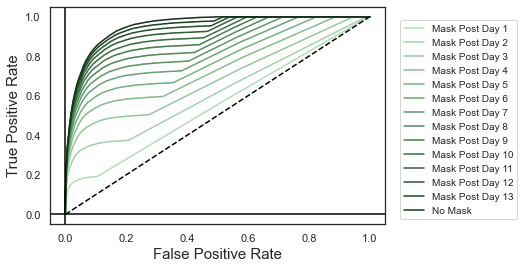

In [20]:
##############
## FIGURE 1 ##
##############

fig, ax = plt.subplots()
ax.set_facecolor('white')

counter = 1

for color, fpr_tpr_tuple in zip(color_list, fpr_tprs):
    if counter != 14:
        plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='Mask Post Day {0}'.format(counter), color=color)
        counter = counter+1
    elif counter == 14:
        plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='No Mask', color=color)
        
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.41, 0))
plt.savefig('./figures/{0}_roc_curves_Fig_1.{1}'.format(target, figure_format), format=figure_format,
             dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

In [21]:
##############################
## FIGURE 2 LAG EXPERIMENTS ##
##############################             
y_test_lag_dict = dict()    
y_pred_lag_dict = dict()

max_start_day = 7

for start in range(1, max_start_day + 1):
    non_nan = ~y_boolmat_test[:,i,::]
    ### 1 DAY LAGGED EXPERIMENTS ###      
    ### all the first days of every person, all the second days, third days, in a 1D vector
    y_test_lag = [Y_TEST[:,i][non_nan] for i in range(start, TIME_STEPS)]
    y_test_lag = np.concatenate(y_test_lag, axis=0)
    y_test_lag_dict[start] = y_test_lag

    # Selects the second day of "masking from second day onward" up to
    # 14th day from masking 14th day onward => only has the value for paddings in predictions   
    y_pred_lag = [y_pred_mask_dict[i][:,i,::][non_nan] for i in range(start, TIME_STEPS)]
    y_pred_lag = np.concatenate(y_pred_lag, axis=0)
    y_pred_lag_dict[start] = y_pred_lag

    ## LAG ROC ##
    print(f'Day {start} Lag with ROC AUC: {roc_auc_score(y_test_lag, y_pred_lag)}')
    
    (fpr, tpr, thresholds) = roc_curve(y_test_lag, y_pred_lag)
    # Updates the dict created above!!!
    # In the original the first 7 masked fprs and tprs are updated!
    fpr_tpr_dict[mask] = (fpr, tpr)

fpr_tprs = fpr_tpr_dict.values()

Y_TEST_LAG_1 = y_test_lag_dict[1]                             
Y_PRED_LAG_1 = y_pred_lag_dict[1]


confusion_matrix(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1))

## 100% Training Data with 1 day lag ##
TN, FP, FN, TP = confusion_matrix(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1)).ravel()
PPV = TP/(TP+FP)
print("PPV for full model w/ 1 day lag is {0}".format(PPV))
CR = classification_report(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1))

print("Sensitivity for full model w/ 1 day lag is {0}".format(CR.split('\n')[3].split()[2]))

print(classification_report(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1)))

Day 1 Lag with ROC AUC: 0.4777561887151805
Day 2 Lag with ROC AUC: 0.4796209012116982
Day 3 Lag with ROC AUC: 0.4823912760284541
Day 4 Lag with ROC AUC: 0.4852639985863144
Day 5 Lag with ROC AUC: 0.4866282709160316
Day 6 Lag with ROC AUC: 0.4862860040197649
Day 7 Lag with ROC AUC: 0.48507888803438715


<ipython-input-21-0b54f9608637>:41: RuntimeWarning: invalid value encountered in longlong_scalars
  PPV = TP/(TP+FP)
C:\Users\moser\anaconda3\envs\mimic-lstm\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PPV for full model w/ 1 day lag is nan
Sensitivity for full model w/ 1 day lag is 0.00
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     84334
         1.0       0.00      0.00      0.00     10761

    accuracy                           0.89     95095
   macro avg       0.44      0.50      0.47     95095
weighted avg       0.79      0.89      0.83     95095



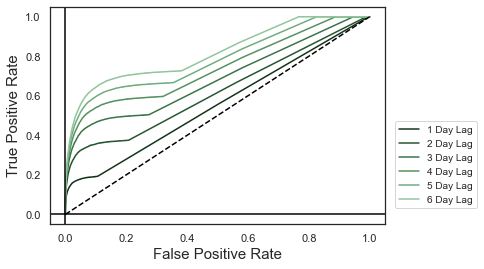

In [22]:
fig, ax = plt.subplots()
ax.set_facecolor('white')

for color, fpr_tpr_tuple, i in zip(np.array(color_list_reduced)[-1:0:-1], fpr_tprs, range(1, max_start_day + 1)):
    plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label='{0} Day Lag'.format(i), color=color)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.29, 0.05))
plt.savefig('./figures/{0}_lagged_roc_curves_Fig_2.{1}'.format(target, figure_format), format=figure_format,
             dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

<ipython-input-23-02bccef9dafd>:11: RuntimeWarning: Mean of empty slice
  heatmap(np.nanmean(activations,axis=0).T[arranged_indices],
<ipython-input-23-02bccef9dafd>:27: RuntimeWarning: Mean of empty slice
  y_vector = np.nanmean(np.nanmean(activations,axis=0).squeeze(), axis=1)
<ipython-input-23-02bccef9dafd>:30: RuntimeWarning: Mean of empty slice
  plot = sns.barplot(x=list(range(14)), y=np.nanmean(np.nanmean(activations,axis=0).squeeze(), axis=1),


There is a 0.002756774663201758 % change between day 0 and 1


<ipython-input-23-02bccef9dafd>:43: RuntimeWarning: Mean of empty slice
  y_vector = np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
<ipython-input-23-02bccef9dafd>:45: RuntimeWarning: Mean of empty slice
  plot = sns.barplot(x=list(range(14)), y=np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0),
<ipython-input-23-02bccef9dafd>:56: RuntimeWarning: Mean of empty slice
  np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
<ipython-input-23-02bccef9dafd>:57: RuntimeWarning: Mean of empty slice
  print(np.array(features)[arranged_indices][np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices],


['inspired o2 fraction_max' 'hemocrit_max' 'diastolic_max' 'diastolic_max'
 'asprin' 'furosemide' 'lisinopril' 'warfarin' 'warfarin' 'warfarin'
 'inspired o2 fraction_std' 'warfarin' 'warfarin' 'warfarin']


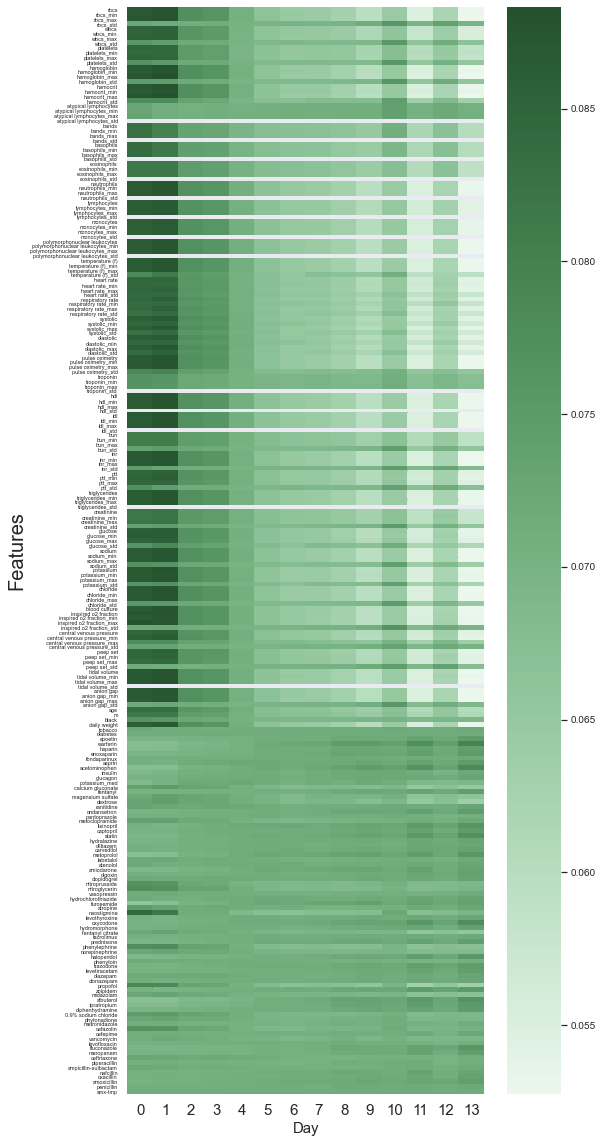

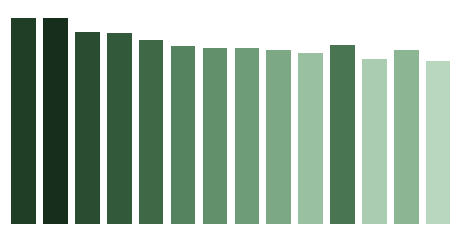

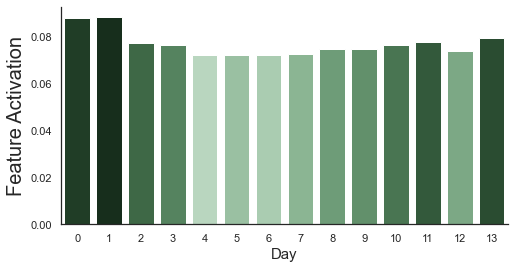

In [23]:
##############
## FIGURE 3 ##
##############

## GET HEATMAPS FOR ALL INCIDENTS AVERAGE ##

plt.figure(figsize = (8,20))

sns.set(font_scale = 0.5)

heatmap(np.nanmean(activations,axis=0).T[arranged_indices], 
        square=False, 
        yticklabels=np.array(features)[arranged_indices],
        cmap=my_cmap)
plt.gcf().axes[-1].tick_params(labelsize=10)
plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Features', fontsize=20)
plt.savefig('./figures/heatmap_{0}_med_ranked_average_activation_Figure_3.{1}'.format(target, figure_format), 
            format=figure_format, dpi=300, bbox_inches='tight')

## MAKE THE BARPLOT THAT GOES ON TOP OF THE HEATMAP ##
## THE ATTENTION ON EVERY TIME STEP AVERAGED OVER FEATURES ##

plt.figure(figsize = (8,4)) 
sns.set(style="white")
y_vector = np.nanmean(np.nanmean(activations,axis=0).squeeze(), axis=1)
print('There is a {0} % change between day 0 and 1'.format((y_vector[1] - y_vector[0])/float(y_vector[0])))
color_rank = np.argsort(np.argsort(y_vector))
plot = sns.barplot(x=list(range(14)), y=np.nanmean(np.nanmean(activations,axis=0).squeeze(), axis=1), 
                    palette=np.array(color_list)[color_rank])
plot.set(xticklabels=[]) 
plot.set(yticklabels=[])
sns.despine(left=True, bottom=True)

plt.savefig('./figures/heatmap_{0}_med_ranked_average_barplot_Figure_3.{1}'.format(target, figure_format), 
            format=figure_format, dpi=300, bbox_inches='tight')

## IDENTIFY MOST IMPORTANT FEATURE AT EVERY TIME STEP ##

plt.figure(figsize = (8,4)) 
sns.set(style="white")
y_vector = np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
color_rank = np.argsort(np.argsort(y_vector))
plot = sns.barplot(x=list(range(14)), y=np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0), 
                    palette=np.array(color_list)[color_rank])
plt.xlabel('Day', fontsize=15)
plt.ylabel('Feature Activation', fontsize=20)
sns.despine()# left=True, bottom=True)

plt.savefig('./figures/{0}_highest_feature_activation_by_timestep_barplot_Figure_3.{1}'.format(target, figure_format), 
            format=figure_format, dpi=300, bbox_inches='tight')

## list of features by day that these activations correspond to ##

np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
print(np.array(features)[arranged_indices][np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices], 
                                                     axis=0)])
#####

In [24]:
def find_intrahospital_incidents():
    IHI_keys =  np.where(np.nansum(Y_TEST.squeeze(), axis=1) > 1)[0]
    for i in IHI_keys:
        predictions = Y_PRED_mask_0[i][~y_boolmat_test[i].squeeze()].squeeze()
        ground_truth = Y_TEST[i].squeeze()[~y_boolmat_test[i].squeeze()].squeeze()
        acc = accuracy_score(np.around(predictions), ground_truth)
        criteria = (acc > .9 and 
                    (np.add(ground_truth, np.around(predictions)) == 2).any()  and
                    (ground_truth[0] == 0) and
                    (np.sum(ground_truth[0:2]) == 0) and
                    1 in ground_truth and
                    ground_truth.shape[0] == 14)
        if criteria:
            print("Person {0} with IHI".format(i))
            print('Ground Truth')
            print(ground_truth)
            print('Predicted Sequence')
            print(np.around(predictions))
            print('\n')
            return i
        
patient_num = find_intrahospital_incidents()

if False:
    if target == 'MI':
        patient_num = 3947
    elif target == 'SEPSIS':
        patient_num = 927
    elif target == 'VANCOMYCIN':
        patient_num = 210#1372 

Person 238 with IHI
Ground Truth
[0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1.]
Predicted Sequence
[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]




In [25]:
def patient_heatmap(X_TEST, patient_num, savefig=False, target=None):   
        if target == None:
            raise Exception('Specify Target')
            
        print('\n')
        print('Visualize Inputs')
        print('Ground Truth')
        ground_truth = Y_TEST[patient_num].squeeze()[~y_boolmat_test[patient_num].squeeze()]
        print(ground_truth)
        print('Predicted Sequence')
        predictions = Y_PRED_mask_0[patient_num].squeeze()[~y_boolmat_test[patient_num].squeeze()]
        print(np.around(predictions))
        
        if target == 'MI':
            color_list_barplot = sns.color_palette("Reds", ground_truth.shape[0])
        elif target == 'SEPSIS':
            color_list_barplot = sns.cubehelix_palette(ground_truth.shape[0], start=2, rot=0, dark=0.25, light=.95)
        elif target == 'VANCOMYCIN':
            color_list_barplot = sns.cubehelix_palette(ground_truth.shape[0])
        
        print('Individual Heatmap')
        plt.figure(figsize = (8,20))
        sns.set(font_scale = 0.5)
        
        activations_map = activations[patient_num]/np.nanmax(activations[patient_num,::,::], axis=1)[:,None]
        heatmap(activations[patient_num].T[arranged_indices],
                square=False,
                yticklabels=np.array(features)[arranged_indices], cmap=my_cmap)
        plt.gcf().axes[-1].tick_params(labelsize=10) 
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15)
        plt.yticks(fontsize=8)
        plt.xlabel('Day', fontsize=20)
        plt.ylabel('Features', fontsize=20)
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
        
        if savefig:
            plt.savefig('./figures/heatmap_{0}_patient_{1}.{2}'.format(target, patient_num, figure_format), 
                        format=figure_format, dpi=300, bbox_inches='tight')
        
        rel_vector = np.nanmean(activations[patient_num,::,::].T.squeeze(), axis=0)
        rel_vector = rel_vector[~y_boolmat_test[patient_num].squeeze()]
        color_order = np.argsort(rel_vector, axis=0)
        color_order_order = np.argsort(color_order)

        plt.figure(figsize = (8,4)) 
        sns.set(style="white")
        plot = sns.barplot(x=np.arange(14)[~y_boolmat_test[patient_num].squeeze()], y=rel_vector, 
                           palette=np.array(color_list_barplot)[color_order_order])
        plot.set(xticklabels=[]) 
        plot.set(yticklabels=[])
        sns.despine(left=True, bottom=True)
        
        print('Patient Features Heatmap')
        if savefig:
            plt.savefig('./figures/barplot_for_heatmap_{0}_patient_{1}.{2}'.format(target, patient_num, figure_format), 
                        format=figure_format, dpi=300, bbox_inches='tight')
        
        plt.figure(figsize= (8,20))
        sns.set(font_scale = 0.5)
        activations_map = X_TEST[patient_num,::,::]/np.nanmax(X_TEST[patient_num,::,::], axis=0) #[:,None]
        heatmap(X_TEST[patient_num,::,::].T[arranged_indices], square=False, 
                yticklabels=np.array(features)[arranged_indices], 
                cmap=my_cmap) #, cbar_kws={'ticks':[]})
        plt.gcf().axes[-1].tick_params(labelsize=10)
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
        plt.yticks(fontsize=8)
        plt.xlabel('Day', fontsize=20)
        plt.ylabel('Features', fontsize=20)
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
        if savefig:
            plt.savefig('./figures/features_heatmap_{0}_patient_{1}.{2}'.format(target, patient_num, figure_format), 
                        format=figure_format, dpi=300, bbox_inches='tight')
            
        rel_vector = np.nanmean(X_TEST[patient_num,::,::].T.squeeze(), axis=0)[~y_boolmat_test[patient_num].squeeze()]
        color_order = np.argsort(rel_vector, axis=0)
        color_order_order = np.argsort(color_order)

        plt.figure(figsize = (8,4)) 
        sns.set(style="white")
        plot = sns.barplot(x=np.arange(14)[~y_boolmat_test[patient_num].squeeze()], y=rel_vector, 
                           palette=np.array(color_list_barplot)[color_order_order])
        plot.set(xticklabels=[]) 
        plot.set(yticklabels=[])
        sns.despine(left=True, bottom=True)
        if savefig:
            plt.savefig('./figures/barplot_features_heatmap_{0}_patient_{1}.{2}'.format(target, patient_num, figure_format), 
                        format=figure_format, dpi=300, bbox_inches='tight')



Visualize Inputs
Ground Truth
[0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1.]
Predicted Sequence
[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
Individual Heatmap
Patient Features Heatmap


<ipython-input-25-f870c2237be1>:60: RuntimeWarning: invalid value encountered in true_divide
  activations_map = X_TEST[patient_num,::,::]/np.nanmax(X_TEST[patient_num,::,::], axis=0) #[:,None]


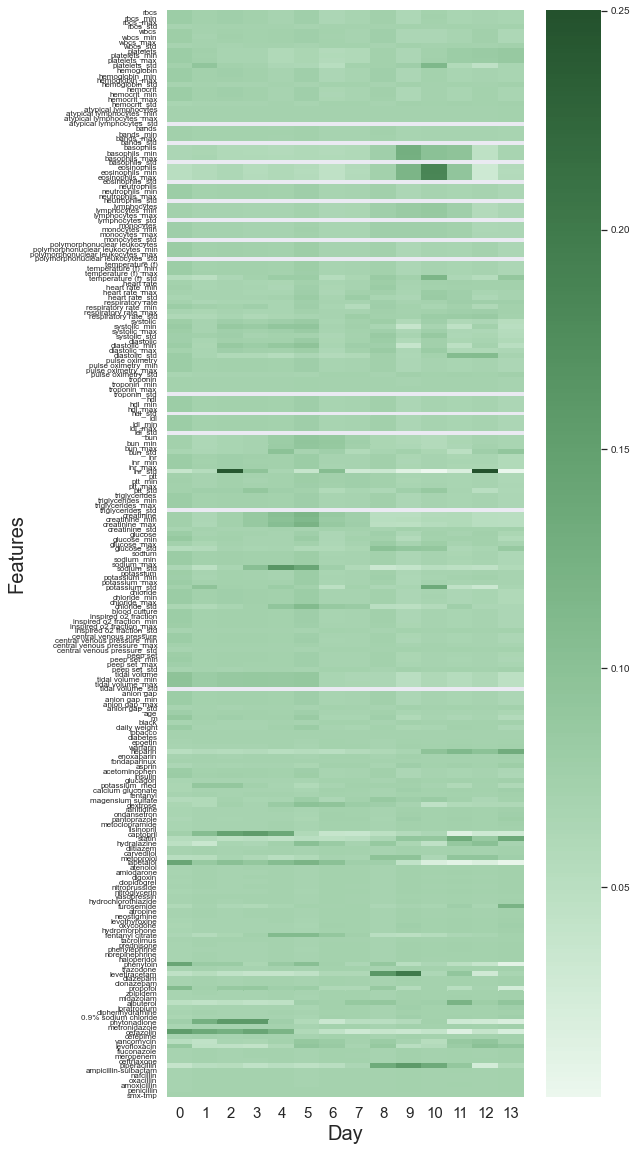

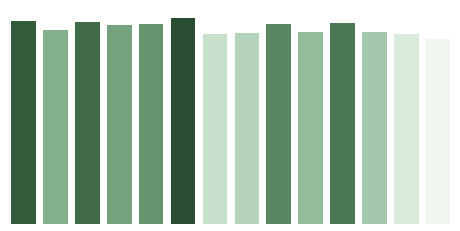

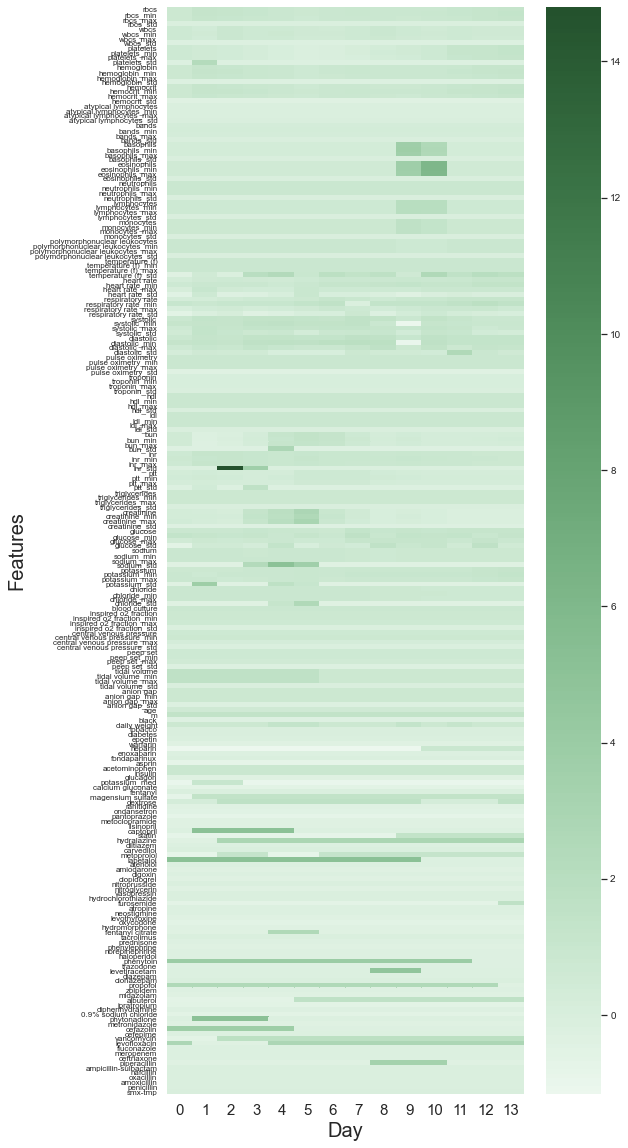

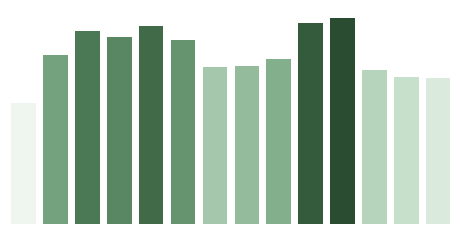

In [26]:
## Example use of patient_heatmap
patient_heatmap(X_TEST.detach().numpy(), patient_num, savefig=True, target=target)

[0.15522645 0.13504964 0.24262086 0.1576037  0.16317955 0.14036301
 0.10636117 0.08748818 0.16281717 0.20002826 0.18606088 0.13309073
 0.2501261  0.1348784 ]
2.254894
['sodium_std' 'sodium_std' 'inr_std']
[0.16317955 0.14036301 0.10636117]


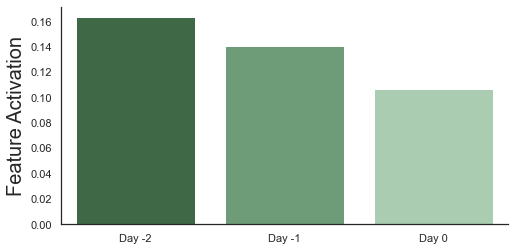

In [27]:
## Get the top activations for that day, the day before, the day before ##

def features_driving_incident(patient_num, savefig=False):
    
    plt.figure(figsize = (8,4)) 
    sns.set(style="white")
    
    if np.where(Y_TEST[patient_num] == 1)[0][0] == 1:
        day_zero = 1
        day_neg_one = 0
        days = np.array([day_neg_one, day_zero])
        days_string = ['Day -1', 'Day 0']
    else:
        assert np.where(Y_TEST[patient_num] == 1)[0][0] >= 2
        day_zero = np.where(Y_TEST[patient_num] == 1)[0][0]
        day_neg_one = day_zero - 1
        day_neg_two = day_zero - 2
        days = np.array([day_neg_two, day_neg_one, day_zero])
        days_string = ['Day -2', 'Day -1', 'Day 0']
       
    y_vector = np.nanmax(activations[patient_num], axis=1)#[days]
    print(y_vector)
    print(np.nansum(y_vector))
    color_rank = np.argsort(np.argsort(y_vector))
    plot = sns.barplot(x=days_string, y=y_vector[days], 
                       palette=np.array(color_list)[color_rank][days])
    plt.ylabel('Feature Activation', fontsize=20)
        #plot.set(xticklabels=[]) 
        #plot.set(yticklabels=[])
    sns.despine() # left=True, bottom=True)

    if savefig:
        plt.savefig('./figures/max_activation_pre_incident_barplot_Figure_4_{0}_patient_{1}.{2}'.format(target, patient_num, figure_format), 
             format=figure_format, dpi=300, bbox_inches='tight')
                   
    ## list of features by day that these activations correspond to ##

    print(np.array(features)[np.nanargmax(activations[patient_num], axis=1)][days])
    print(np.nanmax(activations[patient_num], axis=1)[days])
    
#####

features_driving_incident(patient_num, savefig=True)
    
#####    

In [28]:
print(activations[patient_num].shape)

print(activations[patient_num].T[features.index('phenylephrine'),1])


(14, 225)
0.070853435


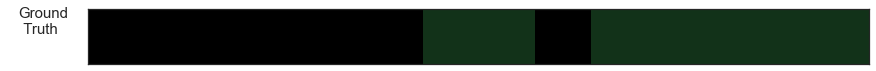

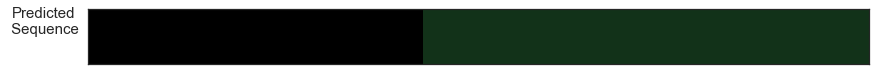

In [29]:
## FIGURE 4 ##

def predictions_labels_palplot(patient_num, savefig=False):
    
    color_list_gt = np.array(color_list.copy())
    color_list_gt[Y_TEST[patient_num].squeeze() == 1] = color_list_gt[-1]
    color_list_gt[Y_TEST[patient_num].squeeze() == 0] = [0,0,0]       
    sns.palplot(color_list_gt)
    plt.ylabel('Ground\n    Truth     ', fontsize=15, rotation='horizontal', labelpad=45) #.set_rotation(0)
    
    if savefig:
        plt.savefig('./figures/{0}_GT_labels_Figure_4.{1}'.format(target, figure_format), format=figure_format,
                dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

    color_list_pred = np.array(color_list.copy())
    color_list_pred[np.around(Y_PRED_mask_0[patient_num].squeeze()) == 1] = color_list_pred[-1]
    color_list_pred[np.around(Y_PRED_mask_0[patient_num].squeeze()) == 0] = [0,0,0]
    sns.palplot(color_list_pred)
    plt.ylabel('Predicted\n Sequence', fontsize=15, rotation='horizontal', labelpad=45)
    if savefig:
        plt.savefig('./figures/{0}_PRED_labels_Figure_4.{1}'.format(target, figure_format), format=figure_format,
                   dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), 
                    bbox_inches='tight')
    
predictions_labels_palplot(patient_num, savefig=True)